In [1]:
import math

import tensorflow as tf
import tensorflow.compat.v1 as tfv1

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence

from datetime import datetime, timedelta
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import time

import os

from IPython.display import display

import matplotlib.pyplot as plt
import multiprocessing

In [2]:
# tfv1.disable_eager_execution()
tfv1.executing_eagerly()

True

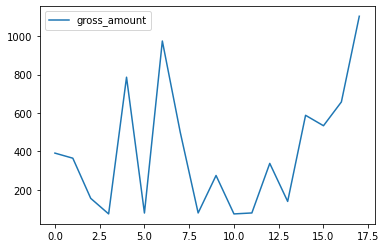

,txn_date,gross_amount
13,2020-08-30,140.00
14,2020-08-31,588.28
15,2020-09-01,534.00
16,2020-09-02,657.80
17,2020-09-03,1103.90


In [3]:
df = pd.read_csv("universe_dataset.csv", usecols=["gross_amount", "txn_date"])

df.plot()
plt.show()

df.tail()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   txn_date      18 non-null     object 
 1   gross_amount  18 non-null     float64
dtypes: float64(1), object(1)
memory usage: 416.0+ bytes


In [5]:
%%time

df['txn_date'] = pd.to_datetime(df['txn_date'])

df.sort_values('txn_date', inplace=True, ascending=True)
df = df.reset_index(drop=True)

print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df['txn_date'].min())
print('The time series ends on: ', df['txn_date'].max())
print("\n")

Number of rows and columns after removing missing values: (18, 2)
The time series starts from:  2020-05-19 00:00:00
The time series ends on:  2020-09-03 00:00:00


CPU times: user 2.94 ms, sys: 3.54 ms, total: 6.48 ms
Wall time: 6.08 ms


In [6]:
# Split into training, validation and test datasets.
# Since it's timeseries we should do it by date.
test_cutoff_date = df['txn_date'].max() - timedelta(days=7)
val_cutoff_date = test_cutoff_date - timedelta(days=14)

df_test = df[df['txn_date'] > test_cutoff_date]
df_val = df[(df['txn_date'] > val_cutoff_date) & (df['txn_date'] <= test_cutoff_date)]
df_train = df[df['txn_date'] <= val_cutoff_date]

#check out the datasets
print('Test dates: {} to {}'.format(df_test['txn_date'].min(), df_test['txn_date'].max()))
print('Validation dates: {} to {}'.format(df_val['txn_date'].min(), df_val['txn_date'].max()))
print('Train dates: {} to {}'.format(df_train['txn_date'].min(), df_train['txn_date'].max()))

df_train.shape, df_val.shape, df_test.shape

Test dates: 2020-08-29 00:00:00 to 2020-09-03 00:00:00
Validation dates: 2020-08-18 00:00:00 to 2020-08-25 00:00:00
Train dates: 2020-05-19 00:00:00 to 2020-08-12 00:00:00


((8, 2), (4, 2), (6, 2))

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
       
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#     ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    
    return ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [8]:
tf.keras.backend.clear_session()

In [ ]:
class CNN_FORECAST:
    def __init__(self, batch_size):
        self.batch_size = batch_size        
        
        # session configuration.
        sess_config = tfv1.ConfigProto(allow_soft_placement=True,
            gpu_options=tfv1.GPUOptions(per_process_gpu_memory_fraction=0.7, allow_growth=True))
        
        self._session = tfv1.Session(config=sess_config)
        
        self.train_acc_metric = keras.metrics.MeanAbsoluteError()
        self.val_acc_metric = keras.metrics.MeanAbsoluteError()
        
    @property
    def _optimizer(self):
        return tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
    
    @property
    def _loss_fn(self):
        return tf.keras.losses.MeanSquaredError(reduction=keras.losses.Reduction.AUTO, name='mean_squared_error')
    
    @property
    def _model(self):
        tf.keras.backend.clear_session()
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),

            tf.keras.layers.LSTM(60, return_sequences=True),
            tf.keras.layers.LSTM(60, return_sequences=True),

            tf.keras.layers.Dense(30, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1),

            tf.keras.layers.Lambda(lambda x: x * 400)
        ])
        
        return model
    
    def _compute_loss(self, actual, predict):
        return self._loss_fn(actual, predict)
    
    def train(self):
        # clear tensflow session.
        tf.keras.backend.clear_session()
        
        # create training and validation dataset
        train_set = self._create_dataset(df_train, window_size=5, batch_size=self.batch_size, shuffle_buffer_size=1)
        val_set = self._create_dataset(df_val, window_size=3, batch_size=self.batch_size, shuffle_buffer_size=1)
               
        # Create a checkpoint directory to store the checkpoints.
        checkpoint_dir = 'training_checkpoints'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        
        ckpt = tfv1.train.Checkpoint(step=tfv1.Variable(1), optimizer=self._optimizer, model=self._model, iterator=iter(train_set))
        manager = tfv1.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=3)
        
        ckpt.restore(manager.latest_checkpoint)
        if manager.latest_checkpoint:
            print("Restored from {}".format(manager.latest_checkpoint))
        else:
            print("Initializing from scratch.")
        
        # Session Configuration
        config = tfv1.ConfigProto(allow_soft_placement=True, log_device_placement=True, intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        
        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.9
                
        with tfv1.Session(config=config) as sess:
            sess.run(tfv1.global_variables_initializer())
            
        for epoch in range(1, 10):
            print(f"Start of epoch %d\n" % (epoch, ))
            start_time = time.time()
            
            # Training loop
            for step, (x_batch_train, y_batch_train) in enumerate(train_set):
                loss = self._train_step(x_batch_train, y_batch_train)
                
            # Display metrics at the end of each epoch.
            train_acc = self.train_acc_metric.result()
            print("Training Loss {:.3f} Training acc over epoch: {:.3f}".format(float(loss), float(train_acc)))

            # Reset training metrics at the end of each epoch
            self.train_acc_metric.reset_states()

            # validation loop
            for x_batch_val, y_batch_val in val_set:                
                self._val_step(x_batch_val, y_batch_val)
                               
            ckpt.step.assign_add(1)
            if int(ckpt.step) % 2 == 0:
                save_path = manager.save()
                print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
                
            print("Time taken: %.2fs" % (time.time() - start_time))
            print("\n")
                               
            
    def _train_step(self, x_batch_train, y_batch_train):   
        model = self._model
        optimizer = self._optimizer
        
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True) # Logits for this minibatch
            loss = self._compute_loss(y_batch_train, logits) # compute the loss value for this minibatch
        
        trainable_variables = model.trainable_variables
        
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        # Update training metric.
        self.train_acc_metric.update_state(y_batch_train, logits)
        return loss

    
    def _val_step(self, x_batch_val, y_batch_val):
        val_logits = self._model(x_batch_val, training=False)
        self.val_acc_metric.update_state(y_batch_val, val_logits)
                
        val_acc = self.val_acc_metric.result()
        self.val_acc_metric.reset_states()

        print("Validation acc: %.4f" % (float(val_acc),))
    

    def _create_dataset(self, df, window_size, batch_size, shuffle_buffer_size):
        tf.random.set_seed(51)
        np.random.seed(51)
        
        return windowed_dataset(df["gross_amount"].values, window_size, batch_size, shuffle_buffer_size)
    
    
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self._session.close()
        
        
cnn = CNN_FORECAST(5)

p = multiprocessing.Process(target=cnn.train)
p.start()
p.join()

In [ ]:
p